## Improved MILP-Based Drone Assignment Strategy (Singles + Pair-Batching)

Algorithm type: Mixed-Integer Linear Programming (MILP) solved with SciPy HiGHS (integrality, presolve, time/gap control).

### Sets
- $\mathcal{I}$: available drones
- $\mathcal{J}$: pending tasks
- $\mathcal{S} = \{\{j,k\} \mid j<k\}$: unordered task pairs

### Parameters
- $\bar d_{ij} \ge 0$: normalized single-route distance for drone $i$ and task $j$
- $\bar e_{ij} \ge 0$: normalized single-route energy for $(i,j)$
- $\bar A_j \in [0,1]$: normalized priority of task $j$
- $\bar d^{(2)}_{iS},\; \bar e^{(2)}_{iS}$: normalized distance/energy for pair $S$ on drone $i$
- $\bar A^{(2)}_S \in [0,1]$: pair priority (sum of member priorities, damped)
- $E_i^{\max} > 0$: available battery (Wh); $\sigma \in [0,1)$ safety reserve (use $(1-\sigma)E_i^{\max}$)
- $w_{ij},\; w^{(2)}_{iS} \in \{0,1\}$: feasibility gates (energy/range based)
- $Q_i \in \mathbb{Z}_+$: per-drone capacity (pairs count as 2)
- $\alpha,\beta,\gamma \ge 0$: weights for distance/energy/priority
- $\eta \ge 0$: pair-set preference factor (scaled by fleet busyness in code)
- $\rho_j \ge 0$: drop penalty per task $j$

### Decision Variables
- $x_{ij} \in \{0,1\}$: drone $i$ takes task $j$ (single)
- $z_{iS} \in \{0,1\}$: drone $i$ takes pair $S=\{j,k\}$ in one round
- $y_j \in \{0,1\}$: drop/defer task $j$

### Objective (minimize)
$$\begin{aligned}
& \min \sum_{i \in \mathcal{I}} \sum_{j \in \mathcal{J}} ( \alpha\, \bar d_{ij} + \beta\, \bar e_{ij} + \gamma\,(1- \bar A_j) )\, x_{ij} \\ 
&\; + \; \eta \sum_{i \in \mathcal{I}} \sum_{S \in \mathcal{S}} ( \alpha\, \bar d^{(2)}_{iS} + \beta\, \bar e^{(2)}_{iS} + \gamma\,(1- \bar A^{(2)}_{S}) )\, z_{iS} \\ 
&\; + \; \sum_{j \in \mathcal{J}} \rho_j \; y_j
\end{aligned}$$

Interpretation:
- $\alpha\, \bar d$: minimize total distance (efficiency) — shorter routes preferred.
- $\beta\, \bar e$: minimize energy (battery health/availability).
- $\gamma(1-\bar A)$: maximize priority ($\bar A$ 높을수록 비용 감소).
- $\eta$ term: encourage efficient two-task batching when fleet is busy.
- $\rho y$: penalize drops to increase completion rate (tunable per policy).

### Constraints
1) Assignment (exactly one of single/pair/drop per task):
$$ \forall j \in \mathcal{J}: \sum_{i \in \mathcal{I}} x_{ij} + \sum_{i \in \mathcal{I}} \sum_{S \in \mathcal{S}: \; j \in S} z_{iS} + y_j = 1 $$
Explanation: every task is either assigned as a single, included in exactly one pair, or dropped.

2) Capacity per drone (pairs count as 2):
$$ \forall i \in \mathcal{I}: \sum_{j \in \mathcal{J}} x_{ij} + 2 \sum_{S \in \mathcal{S}} z_{iS} \le Q_i $$
Explanation: a pair consumes two task slots on a drone's round capacity.

3) Battery (Wh):
$$ \forall i \in \mathcal{I}: \sum_{j \in \mathcal{J}} e_{ij} x_{ij} + \sum_{S \in \mathcal{S}} e^{(2)}_{iS} z_{iS} \le (1-\sigma) E_i^{\max} $$
Explanation: enforce usable energy budget with safety margin $\sigma$.

4) Feasibility gates:
$$ x_{ij} \le w_{ij}, \quad z_{iS} \le w^{(2)}_{iS} $$
Explanation: pre-filter unreachable (range/energy) combinations.

### Normalization and Data Construction
- Singles: $\bar d, \bar e$ from per-drone route distance/energy; $\bar A$ from task priority.
- Pairs: $\bar d^{(2)}, \bar e^{(2)}$ via base $\rightarrow$ pickup $\rightarrow$ pickup $\rightarrow$ drop $\rightarrow$ drop $\rightarrow$ base heuristic; $\bar A^{(2)}= \bar A_j + \bar A_k$ (damped).
- Gates $w, w^{(2)}$: set by range/energy feasibility under $(1-\sigma)E$.

### Batching and Dynamics
- Solve tasks in batches (e.g., $\text{TASK\_BATCH\_SIZE} \approx \sqrt{|\mathcal{I}|}$) per $\text{WAITING\_TIME}$.
- Scale pair weight using $\eta\cdot \text{busy\_percentage}$ to prefer batching when fleet load is high.

### Practical Notes
- $\rho$ tuning: higher $\rho$ reduces drops; per-task $\rho_j$ enables SLA-aware policies.
- Limit pair candidates (top-$k$ nearby) to control problem size without losing much quality.
- Use sparse matrices for constraints in large instances (performance).

### Solver Settings
- HiGHS MILP via `scipy.optimize.milp` with integrality, presolve, `time_limit`, `mip_rel_gap`.


In [1]:
from Common import DroneAssignmentsProblemSimulator, SimPlot
from Config import (
    BATCH_SIZE,
    CLUSTER_DATA_FILE,
    DATA_CSV_FILE,
    DRONE_COUNT,
    DT,
    EXPECT_CSV_FILE,
    N_CLUSTERS,
    WAITING_TIME,
    J,
)
from dronesim.mission import DeliveryTask
from dronesim.unit import Minute, Time
from dronesim.vehicles import DeliveryDrone

In [2]:
# MILP Optimization Hyperparameters
# Objective Function Weight Coefficients

ALPHA, BETA, GAMMA = 3.0, 1.0, 2  # Distance, Energy, Priority weights
ETA = 0.8  # Multi-task set preference factor (0.9 = slight preference for sets)

# Constraint Parameters
SIGMA = 0.1  # Safety margin ratio (reserves 20% of battery capacity)

# Solver Parameters
TIME_LIMIT = 600.0      # Solver time limit in seconds
MIP_REL_GAP = 1e-3    # Relative optimality gap

# Drop Penalty Configuration
# ⚠️ IMPORTANT: RHO should be calibrated based on normalized cost range!
# Normalized assignment cost range: [-GAMMA, ALPHA+BETA] = [-1.5, 3.0]
#
# RHO Calibration Guide:
# - RHO = 0.8 * (ALPHA + BETA + GAMMA) = 3.6  → Drop if cost > 3.6 (very aggressive, max efficiency)
# - RHO = 1.0 * (ALPHA + BETA + GAMMA) = 4.5  → Drop if cost > 4.5 (efficiency-first) ✅ RECOMMENDED
# - RHO = 1.2 * (ALPHA + BETA + GAMMA) = 5.4  → Drop if cost > 5.4 (balanced)
# - RHO = 1.5 * (ALPHA + BETA + GAMMA) = 6.75 → Drop if cost > 6.75 (conservative, rarely drops)
# - RHO = 2.0 * (ALPHA + BETA + GAMMA) = 9.0  → Almost never drop (force assignment)
#
# Note: Since max normalized cost = ALPHA + BETA = 3.0,
#       RHO > 3.0 means "always assign unless physically impossible"

RHO = (ALPHA + BETA + GAMMA) * 10.0      # Efficiency-first: drops inefficient tasks ✅
# TODO
from math import sqrt

TASK_BATCH_SIZE = int(sqrt(DRONE_COUNT))  # Optimal batch size for 230 drones (√230 ≈ 15, use 2-3x)
# TASK_BATCH_SIZE = 10  # Optimal batch size for 230 drones (√230 ≈ 15, use 2-3x)
TASKS_COUNT_PER_ASSIGNMNETS = 2
TASK_QUEUE_PER_DRONE=10
DELVIERYS_PER_CHARGE=10
WAITING_TIME = Minute(1)  # Longer wait = better batching = better optimization
# Option 2: Task-specific penalty based on characteristics
# rho_j can be calculated per task based on:
# - Task priority/urgency
# - Customer tier/service level
# - Delivery time window constraints
# - Distance from depot
#
# Example implementations:
# rho_j = base_penalty * priority_multiplier
# rho_j = base_penalty * (1 + urgency_factor)
# rho_j = base_penalty * (2.0 if is_premium_customer else 1.0)

# Recommended Drop Penalty Strategies:
# 1. Max Efficiency: rho = 0.8-1.0 * (alpha + beta + gamma) - aggressively drop inefficient tasks ✅
# 2. Balanced: rho = 1.2-1.5 * (alpha + beta + gamma) - drop only clearly inefficient tasks
# 3. High Completion: rho = 2.0+ * (alpha + beta + gamma) - virtually never drop

In [3]:
from __future__ import annotations

from itertools import combinations

import numpy as np
from scipy.optimize import Bounds, LinearConstraint, milp


def build_milp_problem(
    n_drone,
    n_task,
    d_bar,          # shape: (I, J)
    e_bar,          # shape: (I, J)
    a_bar,          # shape: (J,)
    e,              # shape: (I, J)  -- Wh for battery constraint
    w,              # shape: (I, J)  -- 0/1 gate for singles (if you still use it)
    Q,              # shape: (I,)
    E,              # shape: (I,)
    rho=None,       # shape: (J,)
    # --- NEW for pair (= two-pick) mode ---
    d2_bar=None,    # shape: (I, S)  normalized pair distance d_{i{j,k}}, S = C(J,2)
    e2_bar=None,    # shape: (I, S)  normalized pair energy
    e2=None,        # shape: (I, S)  Wh for battery constraint on pairs
    a2_bar=None,    # shape: (S,)    normalized pair priority sums
    eta: float = 1.0,   # hyperparameter for pair term
    w2=None,        # optional gate for pairs, shape: (I, S); if None, all ones
):
    """Build MILP for drone-task assignment with optional pair (two-pick) variables.

    Variable order: [ x_{ij} ]_{i,j}  ||  [ z_{iS} ]_{i,S}  ||  [ y_j ]_j
    where S runs over unordered pairs of tasks (j<k).

    Returns:
        c, bounds, constraints, ub_x, battery_limit, extras
    extras contains:
        - 'pairs': list of (j, k) (length S = C(J,2))
        - 'ub_z': (I, S) upper bounds actually applied
        - 'var_slices': dict with slices for ('x','z','y') to help integrality & decoding
    """
    n_drones = n_drone
    n_tasks = n_task

    # ---- index helpers ----
    pairs = [(j, k) for j, k in combinations(range(n_tasks), 2) if k != j]
    n_pairs = len(pairs)

    def idx_x(i, j): return i * n_tasks + j
    def idx_z(i, s): return n_x + i * n_pairs + s
    def idx_y(j):     return n_x + n_z + j

    # ---- sizes ----
    n_x = n_drones * n_tasks
    n_z = n_drones * n_pairs if (d2_bar is not None and e2_bar is not None and e2 is not None) else 0
    n_y = n_tasks
    n_total = n_x + n_z + n_y

    # ---- objective ----
    # singles
    c_x = (ALPHA * d_bar + BETA * e_bar + GAMMA * (1-a_bar[None, :]))  # (I,J)
    if rho is None:
        rho = RHO * np.ones(n_tasks, float)

    # c = np.ones(n_total, float) * 9899999 # TODO
    c = np.zeros(n_total, float)
    c[:n_x] = c_x.ravel(order="C")

    # pairs
    ub_z = None
    if n_z > 0:
        # use provided a2_bar or calculate from a_bar if not provided
        if a2_bar is None:
            a2_bar = np.array([a_bar[j] + a_bar[k] for (j, k) in pairs], dtype=float)  # (S,)
        # pair objective block (I,S)
        c_z = (ALPHA * d2_bar + BETA * e2_bar + GAMMA * (1 - a2_bar[None, :]))
        c[n_x:n_x + n_z] = (eta * c_z).ravel(order="C")

    # drops
    c[n_x + n_z:] = rho

    # ---- variable bounds ----
    lb = np.zeros(n_total, float)
    ub = np.ones(n_total, float)

    # singles gating
    ub_x = ub[:n_x].reshape(n_drones, n_tasks)
    ub_x[:] = w  # keep your existing gate if you want it

    battery_limit = E
    energy_infeasible_x = (e > (battery_limit[:, None] + 1e-12))
    ub_x[energy_infeasible_x] = 0.0
    ub[:n_x] = ub_x.ravel(order="C")

    # pairs gating
    if n_z > 0:
        if w2 is None:
            w2 = np.ones((n_drones, n_pairs), dtype=float)
        ub_z = ub[n_x:n_x + n_z].reshape(n_drones, n_pairs)
        ub_z[:] = w2
        energy_infeasible_z = (e2 > (battery_limit[:, None] + 1e-12))
        ub_z[energy_infeasible_z] = 0.0
        ub[n_x:n_x + n_z] = ub_z.ravel(order="C")

    bounds = Bounds(lb, ub)

    # ---- constraints ----
    constraints = []

    # (1) Assignment: for each task j, exactly one of {single, any pair containing j, drop}
    A_eq = np.zeros((n_tasks, n_total), float)
    for j in range(n_tasks):
        # singles
        for i in range(n_drones):
            A_eq[j, idx_x(i, j)] = 1.0
        # pairs that contain j
        if n_z > 0:
            for s, (p, q) in enumerate(pairs):
                if j == p or j == q:
                    for i in range(n_drones):
                        A_eq[j, idx_z(i, s)] = 1.0
        # drop
        A_eq[j, idx_y(j)] = 1.0
    constraints.append(LinearConstraint(A_eq, lb=np.ones(n_tasks), ub=np.ones(n_tasks)))

    # (2) Capacity per drone: single=1, pair=2
    A_cap = np.zeros((n_drones, n_total), float)
    for i in range(n_drones):
        # singles
        for j in range(n_tasks):
            A_cap[i, idx_x(i, j)] = 1.0
        # pairs
        if n_z > 0:
            for s in range(n_pairs):
                A_cap[i, idx_z(i, s)] = 2.0
    constraints.append(LinearConstraint(A_cap, lb=-np.inf*np.ones(n_drones), ub=Q.astype(float)))

    # (3) Battery: sum of Wh for singles + pairs <= (1-sigma)E
    A_batt = np.zeros((n_drones, n_total), float)
    for i in range(n_drones):
        # singles
        for j in range(n_tasks):
            if ub_x[i, j] > 0.0:
                A_batt[i, idx_x(i, j)] = e[i, j]
        # pairs
        if n_z > 0:
            for s in range(n_pairs):
                if ub_z[i, s] > 0.0:
                    A_batt[i, idx_z(i, s)] = e2[i, s]
    constraints.append(LinearConstraint(A_batt, lb=-np.inf*np.ones(n_drones),
                                        ub=battery_limit.astype(float)))

    # helpful slices for integrality/decoding
    var_slices = {
        "x": slice(0, n_x),
        "z": slice(n_x, n_x + n_z),
        "y": slice(n_x + n_z, n_total),
    }

    extras = {
        "pairs": pairs,          # list[(j,k)]
        "ub_z": ub_z,            # None if no pair mode
        "var_slices": var_slices # to build integrality vector / decode solution
    }

    return c, bounds, constraints, ub_x, battery_limit, extras



def solve_and_parse(c, bounds, constraints, n_drones, n_tasks):
    """Solve MILP and parse results."""
    pairs = [(j, k) for j, k in combinations(range(n_tasks), 2) if k != j]
    S = len(pairs)

    # --- sizes & offsets ---
    n_x = n_drones * n_tasks
    n_z = n_drones * S
    n_y = n_tasks
    n_total = n_x + n_z + n_y
    assert n_total == len(c), f"len(c)={len(c)} but expected {n_total} (= x+z+y)."

    # --- solve ---
    integrality = np.ones(n_total, dtype=int)
    res = milp(
        c=c,
        integrality=integrality,
        bounds=bounds,
        constraints=constraints,
        options={"time_limit": TIME_LIMIT, "mip_rel_gap": MIP_REL_GAP, "presolve": True},
    )

    # --- defaults ---
    x_bin = np.zeros((n_drones, n_tasks), dtype=int)
    z_bin = np.zeros((n_drones, S), dtype=int) if S > 0 else np.zeros((n_drones, 0), dtype=int)
    y_bin = np.zeros(n_tasks, dtype=int)

    # --- parse solution vector in order: x | z | y ---
    if getattr(res, "x", None) is not None:
        off = 0
        # x
        x_raw = res.x[off:off + n_x].reshape(n_drones, n_tasks)
        off += n_x
        # z
        if S > 0:
            z_raw = res.x[off:off + n_z].reshape(n_drones, S)
            off += n_z
        # y
        y_raw = res.x[off:off + n_y]

        x_bin = (x_raw > 0.5).astype(int)
        if S > 0:
            z_bin = (z_raw > 0.5).astype(int)
        y_bin = (y_raw > 0.5).astype(int)

    # --- lists for execution ---
    assigned = [(i, j) for i in range(n_drones) for j in range(n_tasks) if x_bin[i, j] == 1]
    pair_assigned = []
    if S > 0:
        for i in range(n_drones):
            for p in range(S):
                if z_bin[i, p] == 1:
                    pair_assigned.append((i, pairs[p]))  # (drone_idx, (task_j, task_k))

    dropped = [j for j in range(n_tasks) if y_bin[j] == 1]
    objective = float(res.fun) if getattr(res, "fun", None) is not None else float("inf")

    return {
        "x_bin": x_bin,
        "y_bin": y_bin,
        "assigned": assigned,
        "pair_assigned": pair_assigned,   # <- 채워짐
        "dropped": dropped,
        "objective": objective,
        "status": res.status,
        "message": res.message,
    }

def validate_solution(result, data, battery_limit):
    """Validate solution satisfies all constraints."""
    x_bin, y_bin = result['x_bin'], result['y_bin']

    assert np.all(x_bin.sum(axis=0) + y_bin == 1), "Assignment constraint violated"
    assert np.all(x_bin.sum(axis=1) <= data['capacity']), "Capacity constraint violated"
    assert np.all((data['e'] * x_bin).sum(axis=1) <= battery_limit + 1e-6), "Battery constraint violated"
    assert np.all(x_bin <= data['w'] + 1e-9), "Distance gate constraint violated"

In [ ]:
class MILPDroneAssignmentStrategy(DroneAssignmentsProblemSimulator):
    """MILP-Based Optimal Drone Assignment Strategy using Mixed-Integer Linear Programming.

    This strategy formulates the drone-task assignment problem as a MILP optimization
    problem and finds the globally optimal solution considering multiple objectives:
    - Minimize total flight distance
    - Minimize energy consumption
    - Maximize task priority satisfaction
    - Minimize task drops

    The optimizer respects all physical constraints:
    - Battery capacity limits with safety margins
    - Drone task capacity limits
    - Operational range constraints
    """

    def __init__(self, drone_count: int = 50, waiting_time: Time = Minute(1), debug = False):
        super().__init__(CLUSTER_DATA_FILE, drone_count, N_CLUSTERS)
        self.current = waiting_time
        self.waiting_time = waiting_time
        self.one_task = 0
        self.two_task = 0
        self.debug = debug
        if self.debug:
            with open("milp_debug.log", "w") as f:
                f.write(f"{'time':>12s} ")
                f.write(f"{'n_pr':>5s} {'n_x':>5s} {'n_z':>5s} {'n_y':>5s} ")
                f.write(f"{'cx_avg':>6s} {'cx_min':>6s} {'cx_max':>6s} ")
                f.write(f"{'cz_avg':>6s} {'cz_min':>6s} {'cz_max':>6s} ")
                f.write(f"{'eta':>5s} {'Q_mn':>5s} {'Q_mx':>5s} {'Q_av':>5s}\n")

    def sim_update(self, dt, now):
        """Update simulation by solving MILP optimization for pending tasks."""
        if now < self.current:
            return
        self.current += self.waiting_time

        tasks_list = []
        tasks = []

        current_tasks_count = 0
        for task in self.get_pending_tasks():
            tasks.append(task)
            current_tasks_count += 1
            if TASK_BATCH_SIZE > 0 and current_tasks_count >= TASK_BATCH_SIZE:
                tasks_list.append(tasks.copy())
                tasks.clear()

        if len(tasks) != 0:
            tasks_list.append(tasks.copy())

        for tasks in tasks_list:
            if len(tasks) == 0:
                continue
            available_drones = [
                drone for drone in self.get_vehicles() if drone.can_accept_task()
            ]
            if len(available_drones) == 0:
                for task in tasks:
                    self.failed_to_assign_task(task, self.waiting_time)
                continue
            # Prepare optimization data
            n_drones = len(available_drones)
            n_tasks = len(tasks)
            # print(n_drones, n_tasks)

            # Build parameter matrices
            (d_bar, e_bar, a_bar, e, w, Q, E, pairs, d2_bar, e2_bar, e2, w2, a2_bar) = self._build_optimization_data(
                    tasks, available_drones
            )
            # Build and solve MILP problem
            try:
                vehicles = self.get_vehicles()
                busy_percentage = 1.0 - (sum([1 for v in vehicles if v.is_busy]) / len(vehicles)) * 0.5

                c, bounds, constraints, ub_x, battery_limit, extras = build_milp_problem(
                    n_drone=n_drones,
                    n_task=n_tasks,
                    d_bar=d_bar,
                    e_bar=e_bar,
                    a_bar=a_bar,
                    e=e,
                    w=w,
                    Q=Q,
                    E=E,
                    rho=RHO,
                    # --- pairs ---
                    d2_bar=d2_bar,                  # shape: (n_drones, n_pairs)
                    e2_bar=e2_bar,                  # shape: (n_drones, n_pairs)
                    e2=e2,                          # shape: (n_drones, n_pairs)
                    a2_bar=a2_bar,                  # shape: (n_pairs,) pair priority sums
                    w2=w2,                          # shape: (n_drones, n_pairs)
                    eta=ETA * busy_percentage       # 하이퍼파라미터 (두 번 들림 가중)
                )

                # Pair 개수 계산
                pairs = [(j, k) for j, k in combinations(range(n_tasks), 2) if k != j]
                n_x = n_drones * n_tasks
                n_z = n_drones * len(pairs)
                n_y = n_tasks
                n_total = n_x + n_z + n_y

                # 디버그 정보 로그 파일에 저장
                if self.debug:
                    with open("milp_debug.log", "a") as f:
                        f.write(f"{str(now):>12s} ")
                        f.write(f"{len(pairs):>5d} ")
                        f.write(f"{n_x:>5d} ")
                        f.write(f"{n_z:>5d} ")
                        f.write(f"{n_y:>5d} ")

                        # c_x 통계 (평균, 최소, 최대)
                        if n_x > 0:
                            cx_mean = np.mean(c[:n_x])
                            cx_min = np.min(c[:n_x])
                            cx_max = np.max(c[:n_x])
                        else:
                            cx_mean = cx_min = cx_max = 0.0
                        f.write(f"{cx_mean:>6.2f} ")
                        f.write(f"{cx_min:>6.2f} ")
                        f.write(f"{cx_max:>6.2f} ")

                        # c_z 통계 (평균, 최소, 최대)
                        if n_z > 0:
                            cz_mean = np.mean(c[n_x:n_x+n_z])
                            cz_min = np.min(c[n_x:n_x+n_z])
                            cz_max = np.max(c[n_x:n_x+n_z])
                        else:
                            cz_mean = cz_min = cz_max = 0.0
                        f.write(f"{cz_mean:>6.2f} ")
                        f.write(f"{cz_min:>6.2f} ")
                        f.write(f"{cz_max:>6.2f} ")

                        # 나머지
                        f.write(f"{ETA * busy_percentage:>5.2f} ")
                        f.write(f"{Q.min():>5.2f} ")
                        f.write(f"{Q.max():>5.2f} ")
                        f.write(f"{Q.mean():>5.2f}")
                        f.write("\n")

                result = solve_and_parse(
                    c, bounds, constraints, n_drones, n_tasks
                )
                # Status 확인
                if result["status"] == 2:  # Infeasible
                    print("⚠️ Problem is infeasible - no valid assignments possible")
                    for task in tasks:
                        self.failed_to_assign_task(task, self.waiting_time)
                elif result["status"] == 1:  # Time limit
                    print("⏱️ Time limit reached - using best solution found")
                    for task in tasks:
                        self.failed_to_assign_task(task, self.waiting_time)
                # Execute assignments
                else:
                    self._execute_assignments(result, tasks, available_drones)

            except Exception as ex:
                print(f"MILP optimization failed: {ex}")
                # Fallback: mark all tasks as failed
                for task in tasks:
                    self.failed_to_assign_task(task, self.waiting_time)
            finally:
                tasks.clear()

    def _build_optimization_data(
        self, tasks: list[DeliveryTask], drones: list[DeliveryDrone]
    ):
        """Build parameter matrices for MILP optimization (singles + optional pairs)."""
        n_drones = len(drones)
        n_tasks = len(tasks)



        # ---------- singles ----------
        d = np.zeros((n_drones, n_tasks))  # Total flight distance
        e = np.zeros((n_drones, n_tasks))  # Energy consumption (Wh)
        w = np.zeros((n_drones, n_tasks))  # Range feasibility
        priority = np.zeros(n_tasks)  # Task priorities

        d_bar = np.zeros((n_drones, n_tasks))  # Normalized distance
        e_bar = np.zeros((n_drones, n_tasks))  # Normalized energy

        Q = np.zeros(n_drones, dtype=int)  # Drone capacity (task count per round)
        E = np.zeros(n_drones)  # Battery (Wh, available now)

        # ---------- pairs (two-pick) ----------
        # Create unordered task pairs S = {(j,k) | j<k}
        pairs = [(j, k) for j, k in combinations(range(n_tasks), 2) if k != j]
        n_pairs = len(pairs)

        # pair-level matrices; if n_pairs==0, these will have shape (n_drones, 0)
        d2 = np.zeros((n_drones, n_pairs))  # pair route distance
        e2 = np.zeros((n_drones, n_pairs))  # pair energy (Wh)
        w2 = np.zeros((n_drones, n_pairs))  # pair feasibility gate

        d2_bar = np.zeros((n_drones, n_pairs))  # pair normalized distance
        e2_bar = np.zeros((n_drones, n_pairs))  # pair normalized energy

        # ---------- per-drone parameters ----------
        for i, drone in enumerate(drones):
            F = float(drone.transition_duration) * float(drone.velocity)
            if not drone.can_accept_task():
                Q[i] = 0
                E[i] = 0.0
                continue
            Q[i] = TASKS_COUNT_PER_ASSIGNMNETS
            E[i] = float(drone.battery.capacity) * (1 - SIGMA)

        # ---------- per-task (singles) ----------
        for j, task in enumerate(tasks):
            priority[j] = task.priority

            for i, drone in enumerate(drones):
                F = float(drone.transition_duration) * float(drone.velocity)
                if Q[i] == 0:  # not operational
                    continue

                # --- distance/energy for a single task j ---
                # NOTE: assumes drone.route_remainder(task) returns (distance, ...)
                # base_loc = drone.get_nearest_base()
                d_distance, d_energy = drone.estimate_mission_budget(task)
                # base_distance = float(drone.position.distance_to(base_loc))

                # d_distance = F
                # d_distance = base_loc.distance_to(task.origin)
                # d_distance += task.origin.distance_to(task.destination)
                # d_distance += task.destination.distance_to(base_loc)
                # d_distance = float(d_distance)
                d_distance = float(d_distance)
                d_energy = float(d_energy)
                d[i, j] = d_distance

                # Energy model (keep your current formula)
                # e[i, j] = (
                #     (d_distance)
                #     * (float(drone.power_transit) + 0.5 * float(drone.power_per_pakage))
                #     / float(drone.velocity)
                # )
                e[i, j] = d_energy

                # range gate (reachable with current battery, with safety margin SIGMA)
                max_distance = (
                    float(drone.velocity)
                    * E[i]
                    / float(drone.power_transit)
                )

                w[i, j] = 1.0 if d_distance <= max_distance  else 0.0

                # normalizers for singles

                d_bar[i, j] = (
                    min(d[i, j] / max_distance, 1.0) if max_distance > 0 else 1.0
                )
                e_bar[i, j] = (
                    min(e[i, j] / E[i], 1.0)
                )

        # ---------- per-pair (two-pick) ----------
        # We estimate base -> j -> k -> base distance using geometry.
        # If you have a precise "route_remainder for sequence" API, replace this block to use it.
        for i, drone in enumerate(drones):
            F = float(drone.transition_duration) * float(drone.velocity)
            if Q[i] == 0:
                continue

            base = drone.get_nearest_base()  # must provide .distance_to(GeoPoint)

            max_distance = (
                float(drone.velocity)
                * float(drone.battery.capacity)
                / float(drone.power_transit)
                * (1.0 - SIGMA)
            )

            for p, (j, k) in enumerate(pairs):
                # d_distance = 2 * F
                # origins = [tasks[j].origin, tasks[k].origin]
                # origins.sort(key=lambda pt: pt.distance_to(base))
                # destinations = [tasks[j].destination, tasks[k].destination]
                # destinations.sort(key=lambda pt: pt.distance_to(origins[-1]))

                # prev_point = base
                # for point in origins + destinations + [base]:
                #     d_distance += float(prev_point.distance_to(point))
                #     prev_point = point
                d_distance, d_energy = drone.estimate_mission_budget([tasks[j], tasks[k]])
                d_distance = float(d_distance)
                d_energy = float(d_energy)

                # For base-origin round-trip, both orders have same sum: dj + jk + dk
                d2[i, p] = d_distance

                # Energy model for pair (keep consistent with singles; adjust if needed)
                # e2[i, p] = (
                #     d_distance
                #     * (float(drone.power_transit) + float(drone.power_per_pakage))
                #     / float(drone.velocity)
                # )
                e2[i, p] = d_energy

                # print(WattHour.from_si(e2[i, p]))

                # gate: reachable under current battery with margin
                w2[i, p] = 1.0 if d_distance <= max_distance else 0.0

                # normalization
                d2_bar[i, p] = (
                    min(d2[i, p] / max_distance, 1.0) if max_distance > 0 else 1.0
                )
                e2_bar[i, p] = min(e2[i, p] / E[i], 1.0)

        # ---------- priority normalization ----------
        a_bar = priority

        # ---------- pair priority calculation ----------
        a2_bar = np.zeros(n_pairs)  # pair priority sums
        for p, (j, k) in enumerate(pairs):
            a2_bar[p] = priority[j] + priority[k]  # 두 태스크 우선순위 합

        a2_bar = a2_bar * 0.7

        # Return singles + pairs
        # (d_bar, e_bar, a_bar, e, w, Q, E)  +  (pairs, d2_bar, e2_bar, e2, w2, a2_bar)
        return d_bar, e_bar, a_bar, e, w, Q, E, pairs, d2_bar, e2_bar, e2, w2, a2_bar

    def _execute_assignments(self, result, tasks, drones):
        """Execute the optimized assignments to drones (singles + pairs + drops)."""
        handled_task_indices: set[int] = set()
        dropped_set = set(result.get("dropped", []))

        # 1) Handle pair assignments first: (drone_idx, (j, k))
        for drone_idx, pair in result.get("pair_assigned", []):
            j, k = pair
            # Skip if any already handled or marked dropped (safety guard)
            if j in handled_task_indices or k in handled_task_indices:
                continue
            if j in dropped_set or k in dropped_set:
                continue

            drone: DeliveryDrone = drones[drone_idx]
            set_success = True
            assigned_in_set: list[int] = []

            # Try to assign both tasks in the pair
            for task_idx in (j, k):
                task = tasks[task_idx]
                try:
                    ok = bool(drone.assign(task))
                except Exception:
                    ok = False

                if ok:
                    assigned_in_set.append(task_idx)
                else:
                    self.failed_to_assign_task(task, self.waiting_time)
                    set_success = False
                    break

            if set_success:
                handled_task_indices.update((j, k))
                self.two_task += 2
            else:
                # Rollback if possible (optional unassign hook)
                # if hasattr(drone, "unassign"):
                #     for t_idx in assigned_in_set:
                #         try:
                #             drone.unassign(tasks[t_idx])
                #         except Exception:
                            pass

        # 2) Handle single-task assignments: (drone_idx, task_idx)
        for drone_idx, task_idx in result.get("assigned", []):
            if task_idx in handled_task_indices:
                continue
            if task_idx in dropped_set:
                continue

            drone = drones[drone_idx]
            task = tasks[task_idx]
            try:
                ok = bool(drone.assign(task))
            except Exception:
                ok = False

            if ok:
                self.one_task += 1
                handled_task_indices.add(task_idx)
            else:
                self.failed_to_assign_task(task, self.waiting_time)

        # 3) Handle dropped tasks
        for task_idx in result.get("dropped", []):
            if task_idx in handled_task_indices:
                continue
            self.failed_to_assign_task(tasks[task_idx], self.waiting_time)

    def sim_post_update(self, dt, now):
        """Perform any necessary operations after the simulation update."""
        pass

In [5]:
# Run Optimal Distance Assignment Strategy simulation

milp_sim = MILPDroneAssignmentStrategy(DRONE_COUNT, waiting_time=WAITING_TIME, debug=True)
milp_sim.run(DATA_CSV_FILE, lambda task: task.order_time, j = J, dt = DT, batch_size=BATCH_SIZE)


Output()

Clustering 2878 points into 10 clusters

Successfully created 10 cluster bases:

(12.9793 °N/S, 77.6414 °E/W) - Store Count: 575

(12.9499 °N/S, 77.6994 °E/W) - Store Count: 150

(12.9341 °N/S, 77.6152 °E/W) - Store Count: 730

(13.0292 °N/S, 77.571 °E/W) - Store Count: 155

(12.9724 °N/S, 77.6023 °E/W) - Store Count: 277

(12.9137 °N/S, 77.6808 °E/W) - Store Count: 280

(12.9062 °N/S, 77.5968 °E/W) - Store Count: 133

(12.9754 °N/S, 77.6967 °E/W) - Store Count: 143

(12.9703 °N/S, 77.6456 °E/W) - Store Count: 297

(12.9395 °N/S, 77.626 °E/W) - Store Count: 138

╭──────────────────────────────────────────────── Current States ─────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task - ASSIGNED:                   0                                                                           │
│  Task - GO_PICKUP:                  0                                                                           │
│  Task - SERVICE_PICKUP:             0                                                                           │
│  Task - GO_DROPOFF:                 0                                                                           │
│  Task - SERVICE_DROPOFF:            0                                                                           │
│  Task - DONE:                       692                                                                         │
│  Task - ABORTED:                    0                                                                           │
│  Vehicle - GROUNDED:                44                                                                          │
│  Vehicle - TAKING_OFF:              0                                                                           │
│  Vehicle - NAVIGATING:              6                                                                           │
│  Vehicle - LANDING:                 0                                                                           │
│  Vehicle - EMERGENCY:               0                                                                           │
│  Average Task Time:                 00:31:20.204                                                                │
│  Task Time Standard Deviation:      00:08:53.133                                                                │
│  Max Vehicle Utilization:           96.0%                                                                       │
│  Operational Vehicles Percentage:   86.0%                                                                       │
│  Pending Queue Size:                0                                                                           │
│  Cooldown Queue Size:               0                                                                           │
│  Working Queue Size:                0                                                                           │
│  Completed Queue Size:              692                                                                         │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🎯 Assignment Strategy: Single=188 (27.2%), Pair=504 (72.8%)
=== Task Processing Time Analysis ===
Input data points: 692
Valid data points for analysis: 692
=== Task Processing Time Analysis ===
Input data points: 692
Valid data points for analysis: 692
Total simulation tasks: 692
=== Task Processing Time Analysis ===
Input data points: 692
Valid data points for analysis: 692
=== Task Processing Speed Analysis ===
Input data points: 692
Valid data points for analysis: 692
Total simulation tasks: 692
=== Task Processing Speed Analysis ===
Input data points: 692
Valid data points for analysis: 692
=== Vehicle Battery Consumption Analysis ===
Input data points: 414
Valid data points for analysis: 414


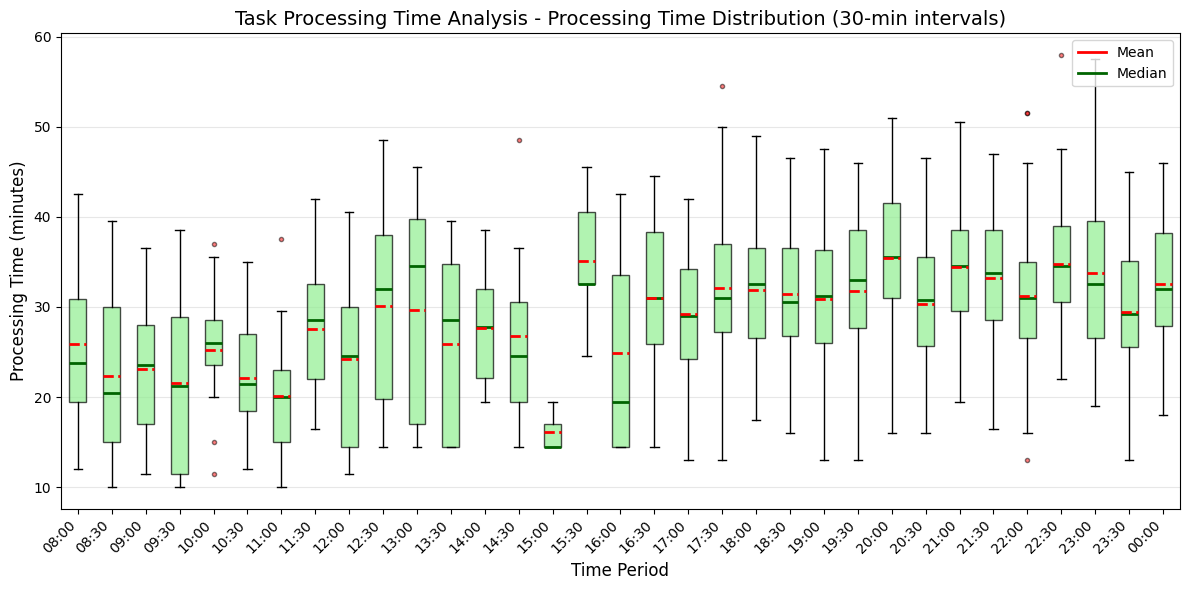

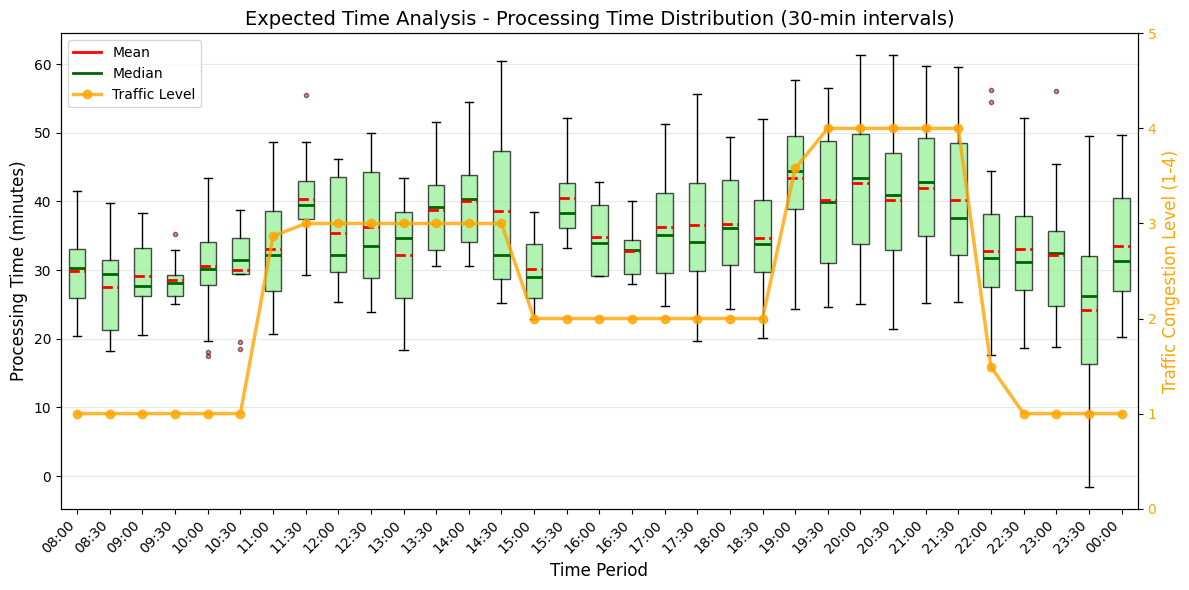

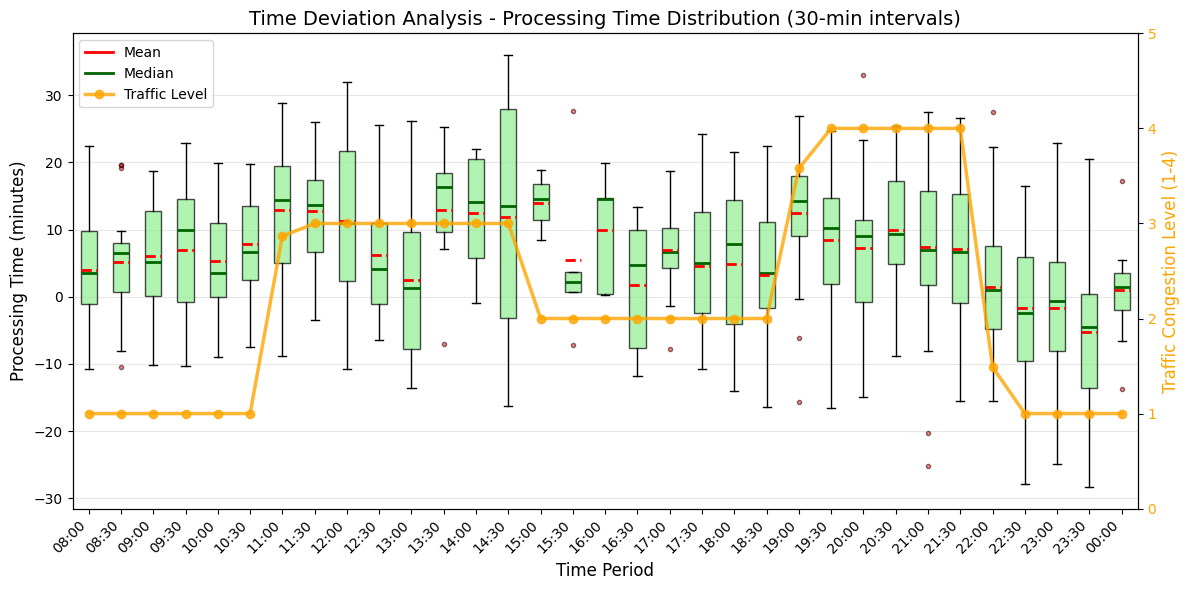

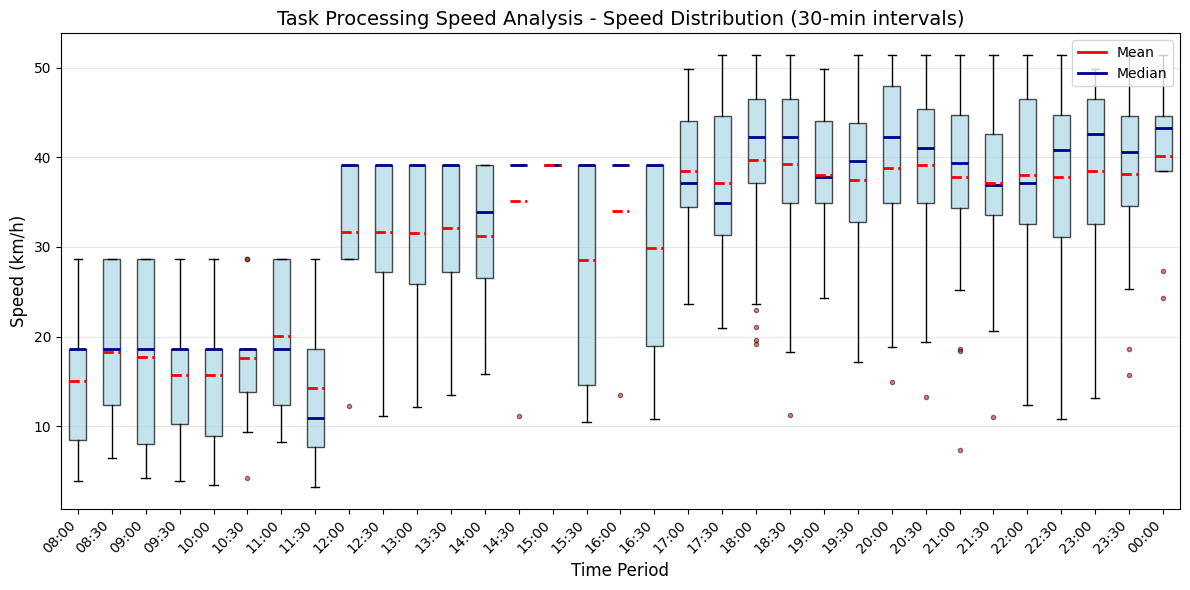

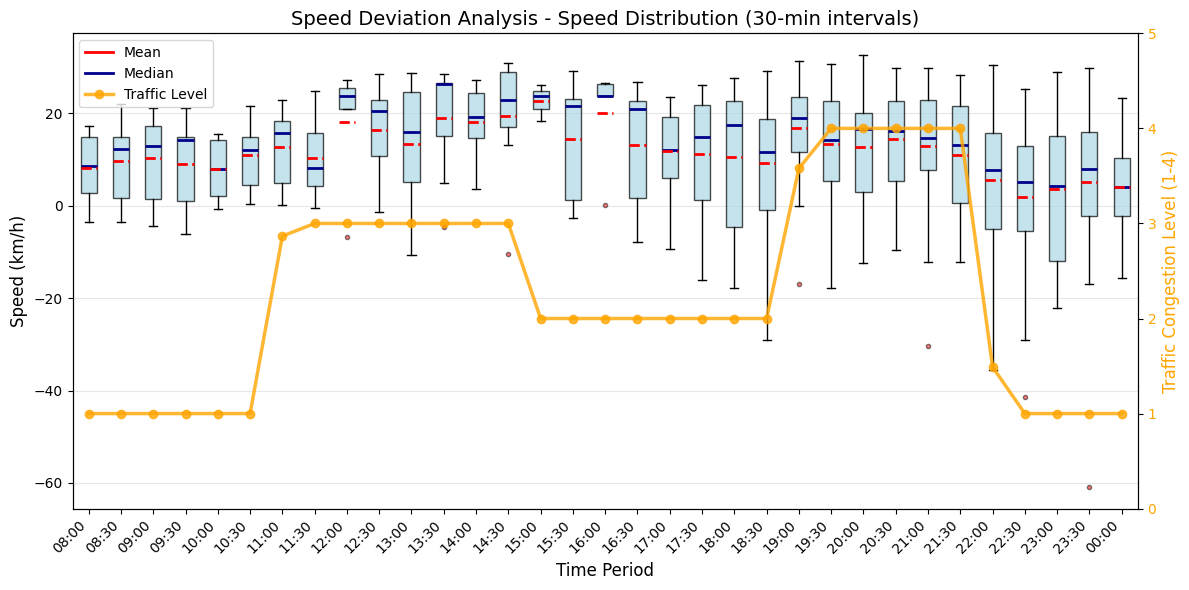

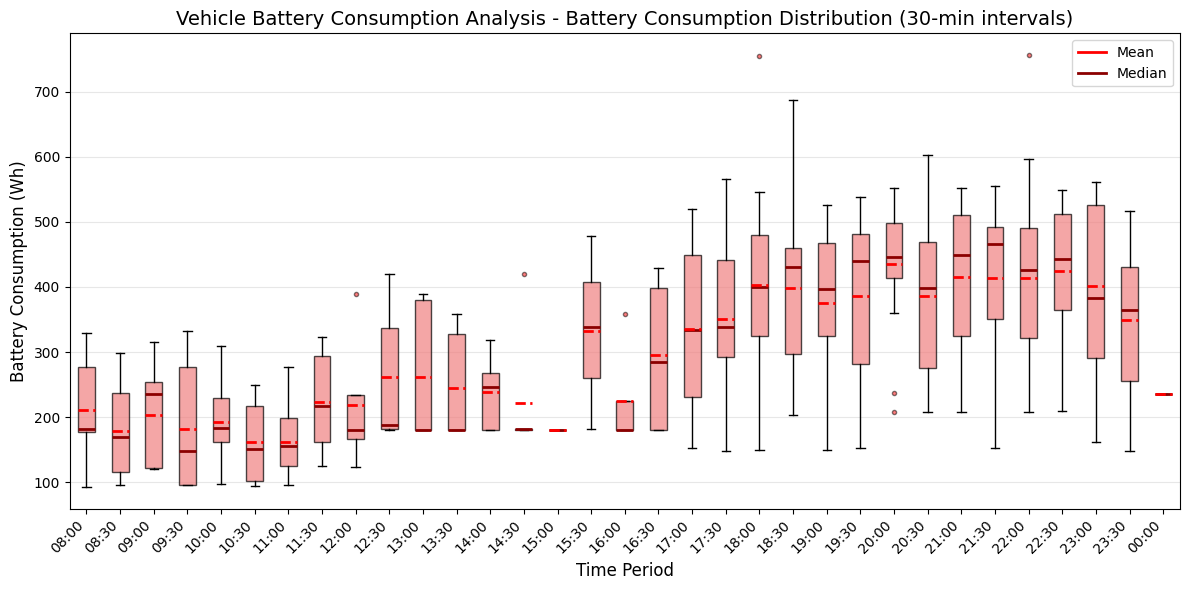

In [6]:
one_task = milp_sim.one_task
total_assignments = one_task + milp_sim.two_task
if total_assignments > 0:
    single_ratio = one_task / total_assignments * 100
    pair_ratio = milp_sim.two_task / total_assignments * 100
    print(f"🎯 Assignment Strategy: Single={one_task} ({single_ratio:.1f}%), Pair={milp_sim.two_task} ({pair_ratio:.1f}%)")
else:
    print(f"🎯 Assignment Strategy: Single={one_task}, Pair={milp_sim.two_task} (No assignments made)")

p_milp = SimPlot(milp_sim, EXPECT_CSV_FILE)
p_milp.task_processing_times()
p_milp.expected_time_analysis()
p_milp.deviation_in_time_taken()
p_milp.task_speed()
p_milp.deviation_speed()
p_milp.battery_usage()
p_milp.show()